dBV -40.0 -14.0
a 0.01 0.19952623149688797
b 1642.2903271498458 32768.0
c 6.0890573576931144e-06
T 0.18575963718820862
dv 5.38330078125
t 0.0 0.18573696145124716 8192


<IPython.core.display.Javascript object>


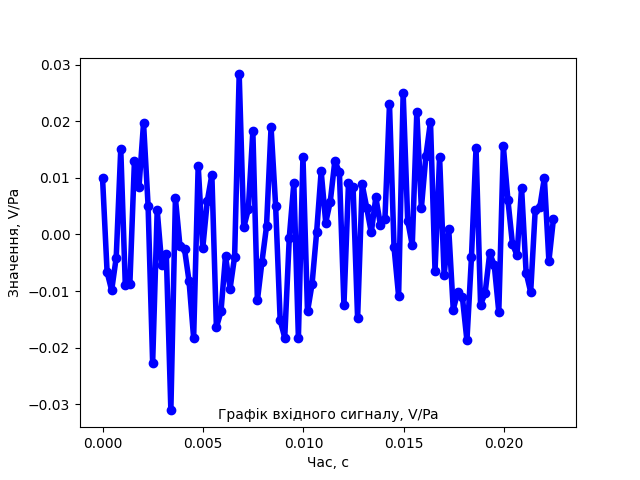

--- 0.0 seconds fft---
L 8192
4096


<IPython.core.display.Javascript object>


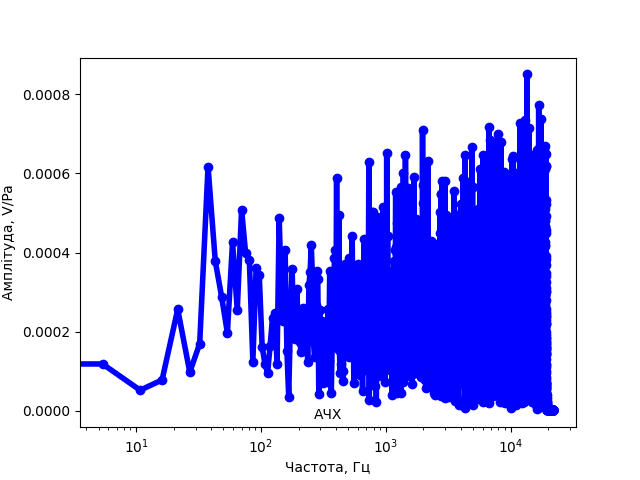

Max_data= 139.69314858036614
MaxVPa= 0.0008505995941825959 V/Pa
V_maxA= 13513.734586741544 Hz
MaxPa= 0.08505995941825958 Pa
dB -21.405496576439468 dB
MaxdBV= -61.40549657643947 dBV
MaxdB= 72.59450342356052 dB
dBAs2= 133.1789375237255
dBAs3= 130.63511094501064


<IPython.core.display.Javascript object>


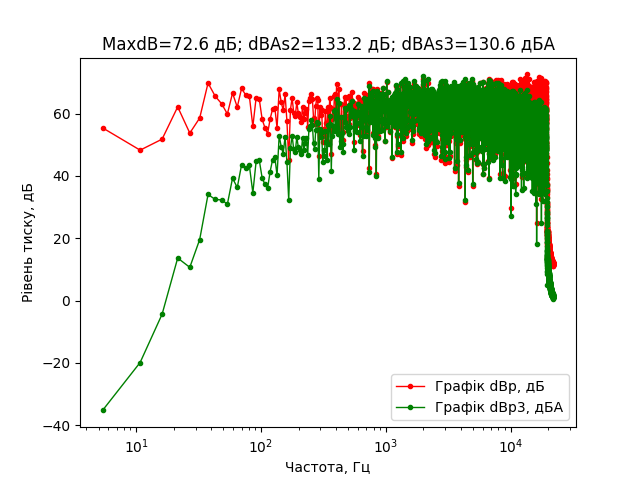

<IPython.core.display.Javascript object>


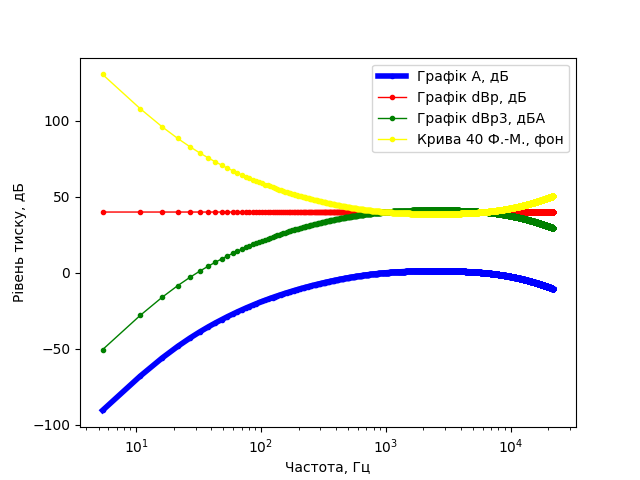

In [3]:
# В РЕЖИМІ РЕАЛЬНОГО ЧАСУ
import pyaudio
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
import time
from tkinter import TclError
import math
import wave

%matplotlib notebook
#inline

#20*LG[1Pa/20*10^(-6)Pa]=94 dB

#рівень звукового тиску (SPL) вхідного сигналу, dB
#рівень вихідного сигналу, dBV

#чутливість мікрофону - це напруга, яка виникає на виході мікрофона*, 
#коли на нього подати синусоїдальний сигнал частотою 1кГц і рівнем звукового тиску 94дБ**, 
#що відповідає тиску 1Па

#Більшість аналогових електретних мікрофонів мають чутливість у діапазоні від –46 до –35 дБ·В, 
#тому будемо вважати, що чутливість мікрофона -40 дБ·В   (-47)

#*мікрофон на відстані 1 метр від гучномовця
#**розмова, на відстані близько 3 см приблизно дорівнює гучності 94 dB
 
#120 dB (SPL) ---  (-21) dBV ---20       Pa ---89.13 mV/Pa --- 32768=2^15
# 94 dB (SPL) ---  (-47) dBV --- 1       Pa --- 4.47 mV/Pa ---  1642.29
#  0 dB (SPL) --- (-141) dBV --- 0.00002 Pa --- 0    mV/Pa ---     0

def RA(v):
    g_1=12194**2*v**4/((v**2+20.6**2)*(v**2+12194**2)*((v**2+107.7**2)*(v**2+737.9**2))**0.5)
    v=1000
    g_2=12194**2*v**4/((v**2+20.6**2)*(v**2+12194**2)*((v**2+107.7**2)*(v**2+737.9**2))**0.5)
    g=20*math.log10(g_1)-20*math.log10(g_2)
    return g

def dB_p(VPa):
    p=VPa/a # переводимо VPa в Pa
    dBp=20*math.log10(p/0.00002)  # визначаємо рівень тиску
    return dBp

def znach(name):
    znach1 = wave.open(name,"r")
    znach1_16 = znach1.readframes(-1)
    znach2 = np.frombuffer(znach1_16, dtype='int16')
    audio_file = wave.open(name)
    CHANNELS2 = audio_file.getnchannels()
    if CHANNELS2==2:
        znach2=znach2[::2]
    return znach2
        
FORMAT = pyaudio.paInt16    #[-32768 ÷ 32767]=2^16   
CHANNELS = 1                
RATE = 44100
CHUNK = 8192  #2^13 
dev_index = 0

filename='White_noise.wav'
znach_1=znach(filename)[:CHUNK]
data=znach_1
#корекція чутливості мікрофона
#розрахунок коефіцієнта перетворення

dBV = -40.0                #-47
dBV0 = dBV+(120-94)        #-21
print('dBV',dBV,dBV0)

a=np.power(10.0,dBV/20.0)   #4.47e-3
a0=np.power(10.0,dBV0/20.0) #89.13e-3
print('a',a,a0)

b0=np.power(2.0,15)        #32768
b=b0*a/a0                  #1642.29
print('b',b,b0)

c=a0/b0
print('c',c)

fps=RATE
Z=CHUNK

#Z=int(fps*T)
T=Z/fps
print('T',T)
#крок частоти 
dv=1/T
print('dv',dv)
#основний тон
#t0=int(fps/v)

dT=1/fps
# вісь часу
t=np.arange(Z)*dT
print('t', t[0], t[-1], len(t))

#перетворення бітів
#data-->V/Pa

data = data*c

#Залежність значень (у V/Pa) вхідного сигналу від часу
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title(r'Графік вхідного сигналу, V/Pa', fontsize=10, x=0.5, y=0)
ax.set_xlabel('Час, с')
ax.set_ylabel('Значення, V/Pa')
ax.plot(t[:1000:10], data[:1000:10], color='blue', marker='o', label="Графік вх. сигналу data*c", linewidth=4)

#ДПФ
start = time.time()
y_1=fft(data)
end = time.time()
t_1=end - start
u="--- %s seconds fft---" % t_1
print("--- %s seconds fft---" % t_1)

#вісь частот
L=len(y_1)
x = np.linspace(0, int((L)/T), L)
print('L',L)
y1=[]
for i in range(L):
    y1.append(abs(y_1[i])/(L/2))

#половина спектру
Z1=int(L/2)
print(Z1)

#АЧХ
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title(r'АЧХ', fontsize=10, x=0.5, y=0)
ax.set_xlabel('Частота, Гц')
ax.set_ylabel('Амплітуда, V/Pa')
ax.set_xscale('log')
#ax.set_yscale('log')
#ax.bar(x[:], y3[:])
ax.plot(x[:Z1], y1[:Z1], color='blue', marker='o', label="Графік АЧХ", linewidth=4)
MaxVPa=max(y1)
Max_data=MaxVPa/c
print('Max_data=',Max_data)
V_maxA=x[np.argmax(y1)]
print('MaxVPa=',MaxVPa,'V/Pa')
print('V_maxA=',V_maxA,'Hz')
MaxPa=MaxVPa*1/a
print('MaxPa=',MaxPa,'Pa')
dB=20*math.log10(MaxVPa/a)
print('dB',dB, 'dB')
MaxdBV=dB+dBV
print('MaxdBV=',MaxdBV,'dBV')
MaxdB=dB+94
print('MaxdB=',MaxdB,'dB')

y1=y1[:len(y1)//2]
L=len(y1)
x = np.linspace(0, int((L)/T), L)
dBA1=[]
dBA2=[]
dBA3=[]
Ps2,Ps3=0,0
for k in range(1,len(x)):
#     print(k)
    dBA1.append(RA(x[k]))
    dBA2.append(dB_p(y1[k]))
    dBA3.append(dBA1[-1]+dBA2[-1])
    Ps2=Ps2+10**(dBA2[-1]/20)
    Ps3=Ps3+10**(dBA3[-1]/20)
dBAs2=20*math.log10(Ps2)
print('dBAs2=',dBAs2)
dBAs3=20*math.log10(Ps3)
print('dBAs3=',dBAs3)
    
    
fig2 = plt.figure()
ax = fig2.add_subplot(1, 1, 1)
ax.set_xscale('log')
ax.plot(x[1:], dBA2, color='red', marker='.', label="Графік dBp, дБ", linewidth=1)
ax.plot(x[1:], dBA3, color='green', marker='.', label="Графік dBp3, дБА", linewidth=1)
ax.set_xlabel('Частота, Гц')
ax.set_ylabel('Рівень тиску, дБ')
plt.legend()
s='MaxdB='+str(round(MaxdB,1))+' дБ; dBAs2='+str(round(dBAs2,1))+' дБ; dBAs3='+str(round(dBAs3,1))+' дБА'
ax.set_title(s)
fig2.savefig('Real3.png', dpi = 1000)

fig3 = plt.figure()
ax3 = fig3.add_subplot(1, 1, 1)
ax3.set_xscale('log')
ax3.plot(x[1:], dBA1, color='blue', marker='.', label="Графік A, дБ", linewidth=4)
dBA4=[40]*len(dBA2)
ax3.plot(x[1:], dBA4, color='red', marker='.', label="Графік dBp, дБ", linewidth=1)
dBA5,dBA6=[],[]
for k in range(len(dBA2)):
    dBA5.append(dBA1[k]+dBA4[k])
    dBA6.append(dBA4[k]-dBA1[k])
ax3.plot(x[1:], dBA5, color='green', marker='.', label="Графік dBp3, дБА", linewidth=1)
ax3.plot(x[1:], dBA6, color='yellow', marker='.', label="Крива 40 Ф.-М., фон", linewidth=1)
plt.legend()
ax3.set_xlabel('Частота, Гц')
ax3.set_ylabel('Рівень тиску, дБ')
fig3.savefig('Real3_3.png', dpi = 1000)